In [162]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import itertools
import copy
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [ ]:
def plot_training_curves(train_history, eval_history, loss_history, x_tick_size = 10, figsize=(20, 5)):
    """
    학습 곡선, 평가 곡선, Loss 곡선을 별도의 그래프로 시각화하는 함수
    
    Parameters:
        train_history (list): 학습 중 makespan 기록
        eval_history (list): 평가 makespan 기록
        loss_history (list): 학습 중 loss 기록
        figsize (tuple): 전체 그래프 크기 (width, height)
    """
    plt.style.use('default')
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    
    # 1. Training Makespan 그래프
    ax1.plot(train_history, 
            color='#2E86C1',
            linewidth=2,
            markersize=4,
            markerfacecolor='white',
            label='Training Makespan')
    
    start = 0
    end = len(train_history)
    ax1.set_xticks(range(start, end, x_tick_size))
    ax1.set_xticklabels([str(x) for x in range(start, end, x_tick_size)])
    
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    ax1.set_title('Training Makespan', fontsize=14, pad=15)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Makespan', fontsize=12)
    ax1.legend(frameon=True, facecolor='white', edgecolor='none', fontsize=10)
    
    # 2. Evaluation Makespan 그래프
    ax2.plot(eval_history, 
            color='#E74C3C',
            linewidth=2,
            markersize=4,
            markerfacecolor='white',
            label='Evaluation Makespan')
    
    ax2.set_xticks(range(start, end, x_tick_size))
    ax2.set_xticklabels([str(x) for x in range(start, end, x_tick_size)])
    
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    ax2.set_title('Evaluation Makespan', fontsize=14, pad=15)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Makespan', fontsize=12)
    ax2.legend(frameon=True, facecolor='white', edgecolor='none', fontsize=10)
    
    # 3. Loss 그래프
    ax3.plot(loss_history, 
            color='#27AE60',
            linewidth=2,
            markersize=4,
            markerfacecolor='white',
            label='Training Loss')
    
    ax3.set_xticks(range(start, end, x_tick_size))
    ax3.set_xticklabels([str(x) for x in range(start, end, x_tick_size)])
    
    ax3.grid(True, linestyle='--', alpha=0.3)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    ax3.set_title('Training Loss', fontsize=14, pad=15)
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Loss', fontsize=12)
    ax3.legend(frameon=True, facecolor='white', edgecolor='none', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# 단일 인스턴스 + POMO 

In [ ]:
def extract_machine_names(instance_data):
    machines = sorted(list({row["Machine"] for row in instance_data["process_info"]}))
    return machines

class ParallelMachineEnvTimeProgressPOMO:
    def __init__(self, lots, process_info, machines, machine_order=None):
        self.lots = lots
        self.process_info = process_info
        self.machines = sorted(list(machines))
        
        # 마스크 집합 생성 (예: "MSK1/MSK2" → ["MSK1", "MSK2"])
        self.all_masks = set()
        for p in process_info:
            masks = p['Mask_set'].split('/')
            self.all_masks.update(masks)
        self.all_masks = sorted(list(self.all_masks))
        
        # 각 Process_ID에 대해 사용 가능한 머신 집합 계산
        self.process_machines = {}
        for p in process_info:
            self.process_machines.setdefault(p['Process_ID'], set()).add(p['Machine'])
        
        # POMO용 머신 순서
        if machine_order is None:
            self.machine_order = list(range(len(self.machines)))
        else:
            self.machine_order = machine_order
        
        self.job_history = [] # 작업 히스토리 기록용
        
        self.reset()
    
    def reset(self):
        self.current_time = 0
        # 아직 도착하지 않은 로트들 (Lot_ID를 key로)
        self.pending_lots = {lot['Lot_ID']: lot for lot in self.lots}
        # 각 머신별 waiting list 초기화
        self.waiting_lists = {m: [] for m in self.machines}
        # 각 머신의 현재 작업 상태: None이면 Idle, 있으면 작업 정보를 담은 dict
        self.machine_status = {m: None for m in self.machines}
        # 마스크 사용 상태: 0이면 사용 가능, 양의 정수면 남은 사용시간
        self.mask_status = {mask: 0 for mask in self.all_masks}
        # 누적 통계
        self.machine_total_processing_times = {m: 0 for m in self.machines}
        self.machine_completed_jobs = {m: 0 for m in self.machines}
        self.mask_usage_count = {mask: 0 for mask in self.all_masks}
        self.machine_idle_time = {m: 0 for m in self.machines}
        self.completed_jobs = 0
        
        self.job_history = [] # 작업 히스토리 초기화
        return self.get_state()
    
    def _simulate_one_time_unit(self):
        for idx in self.machine_order:
            m = self.machines[idx]
            
            # (1) 머신이 현재 작업 중이면 remaining_time 감소
            if self.machine_status[m] is not None:
                job = self.machine_status[m]
                job['remaining_time'] -= 1
                self.machine_total_processing_times[m] += 1
                
                # 마스크 사용시간도 1 감소
                if self.mask_status.get(job['mask'], 0) > 0:
                    self.mask_status[job['mask']] = max(0, self.mask_status[job['mask']] - 1)
                
                # (1-1) 만약 남은 시간이 0 이하 => 작업 완료
                if job['remaining_time'] <= 0:
                    # 히스토리에 기록
                    self.job_history.append({
                        'machine': m,
                        'lot_id': job['lot']['Lot_ID'],
                        'process_id': job['lot']['Process_ID'],
                        'mask': job['mask'],
                        'start_time': self.current_time - job['process_time'],
                        'duration': job['process_time']
                    })
                    
                    # 완료 처리
                    self.machine_completed_jobs[m] += 1
                    self.completed_jobs += 1
                    self.mask_usage_count[job['mask']] += 1
                    self.mask_status[job['mask']] = 0
                    self.machine_status[m] = None
            
            # (2) 여기서 'if self.machine_status[m] is None:'로 처리
            #    => 방금 완료돼서 None이 된 머신도 포함된다!
            if self.machine_status[m] is None:
                # (2-1) 대기열에서 새 작업 할당 가능하면 처리
                if self.waiting_lists[m]:
                    candidate_jobs = []
                    for lot in self.waiting_lists[m]:
                        # machine m에 맞는 process 정보 찾기
                        process_option = None
                        for p in self.process_info:
                            if p['Process_ID'] == lot['Process_ID'] and p['Machine'] == m:
                                process_option = p
                                break
                        if process_option is None:
                            continue
                        
                        # 사용가능 마스크 확인
                        masks = process_option['Mask_set'].split('/')
                        available_masks = [mask for mask in masks if self.mask_status[mask] == 0]
                        
                        # 마스크 하나라도 사용가능하면 후보에 추가
                        if available_masks:
                            least_used_mask = min(available_masks, key=lambda x: self.mask_usage_count[x])
                            candidate_jobs.append((lot, process_option, least_used_mask))
                    
                    if candidate_jobs:
                        # 예: 처리시간이 가장 짧은 job 선택
                        selected_lot, selected_process, selected_mask = min(
                            candidate_jobs, key=lambda x: x[1]['Processing_time']
                        )
                        # 대기열에서 제거
                        self.waiting_lists[m] = [
                            lot for lot in self.waiting_lists[m] if lot['Lot_ID'] != selected_lot['Lot_ID']
                        ]
                        # 머신에 새 작업 할당
                        self.machine_status[m] = {
                            'lot': selected_lot,
                            'remaining_time': selected_process['Processing_time'],
                            'mask': selected_mask,
                            'process_time': selected_process['Processing_time']
                        }
                        # 마스크도 사용중으로 설정
                        self.mask_status[selected_mask] = selected_process['Processing_time']
                    else:
                        # 후보가 없다면 idle 증가
                        self.machine_idle_time[m] += 1
                else:
                    # 대기열 자체가 비어있으면 idle 증가
                    self.machine_idle_time[m] += 1
        
        # 마지막에 시간 1 증가
        self.current_time += 1

    
    def _system_idle(self):
        return all(self.machine_status[m] is None for m in self.machines) and \
               all(len(self.waiting_lists[m]) == 0 for m in self.machines)
    
    def step(self, action=None):
        ready_lots = [lot for lot in self.pending_lots.values() if lot['Ready_time'] <= self.current_time]
        if ready_lots:
            lot = sorted(ready_lots, key=lambda x: x['Ready_time'])[0]
            if action is None:
                raise ValueError(f"Time {self.current_time}: Lot {lot['Lot_ID']} is ready (or overdue), but no action provided!")
            if action not in self.machines:
                raise ValueError(f"Invalid action: {action} is not a valid machine.")
            process_options = [p for p in self.process_info if p['Process_ID'] == lot['Process_ID'] and p['Machine'] == action]
            if not process_options:
                raise ValueError(f"Machine {action} is not eligible for Lot {lot['Lot_ID']} with process {lot['Process_ID']}.")
            self.waiting_lists[action].append(lot)
            del self.pending_lots[lot['Lot_ID']]
        
        while True:
            ready_lots = [lot for lot in self.pending_lots.values() if lot['Ready_time'] <= self.current_time]
            if ready_lots:
                break
            pending_ready_times = [lot['Ready_time'] for lot in self.pending_lots.values() if lot['Ready_time'] > self.current_time]
            if pending_ready_times:
                next_release_time = min(pending_ready_times)
                if self.current_time < next_release_time:
                    self._simulate_one_time_unit()
                else:
                    break
            else:
                if not self._system_idle():
                    self._simulate_one_time_unit()
                else:
                    break
        
        done = (len(self.pending_lots) == 0 and self._system_idle())
        reward = -self.current_time if done else 0
        info = {'current_time': self.current_time, 'completed_jobs': self.completed_jobs,
                'makespan': self.current_time if done else None}
        return self.get_state(), reward, done, info
    
    def get_state(self):
        state = []
        total_lots = len(self.lots)
        makespan = self.current_time if self.current_time > 0 else 1
        for m in self.machines:
            state.append(len(self.waiting_lists[m]) / total_lots if total_lots > 0 else 0)
        for mask in self.all_masks:
            state.append(1 if self.mask_status.get(mask, 0) == 0 else 0)
        for mask in self.all_masks:
            state.append(self.mask_usage_count[mask])
        next_ready_lot = None
        if self.pending_lots:
            next_ready_lot = sorted(self.pending_lots.values(), key=lambda x: x['Ready_time'])[0]
        if next_ready_lot:
            for m in self.machines:
                if m in self.process_machines.get(next_ready_lot['Process_ID'], []):
                    process = next((p for p in self.process_info if p['Process_ID'] == next_ready_lot['Process_ID'] and p['Machine'] == m), None)
                    state.append(process['Processing_time'] / makespan if process else 0)
                else:
                    state.append(0)
        else:
            state.extend([0] * len(self.machines))
        for m in self.machines:
            state.append(self.machine_total_processing_times[m] / makespan)
        for m in self.machines:
            state.append(self.machine_completed_jobs[m] / total_lots if total_lots > 0 else 0)
        for m in self.machines:
            state.append(self.machine_idle_time[m] / makespan)
        for m in self.machines:
            total_proc_time = 0
            for lot in self.waiting_lists[m]:
                process = next((p for p in self.process_info if p['Process_ID'] == lot['Process_ID'] and p['Machine'] == m), None)
                if process:
                    total_proc_time += process['Processing_time']
            state.append(total_proc_time / makespan)
        for m in self.machines:
            state.append(1 if self.machine_status[m] is None else 0)
        return state


# 배치 및 POMO 래퍼

In [ ]:
class BatchParallelMachineEnvPOMO:
    def __init__(self, batch_data, machines):
        self.batch_size = len(batch_data)
        self.machines = machines
        self.pomo_orders = list(itertools.permutations(range(len(machines))))
        self.num_pomo = len(self.pomo_orders)
        self.batch_envs = []  # [B, num_pomo]
        for data in batch_data:
            lots = data["lots"]
            process_info = data["process_info"]
            instance_envs = []
            for order in self.pomo_orders:
                env = ParallelMachineEnvTimeProgressPOMO(lots, process_info, machines, machine_order=list(order))
                instance_envs.append(env)
            self.batch_envs.append(instance_envs)
    
    def reset(self):
        batch_states = []
        for instance_envs in self.batch_envs:
            instance_states = []
            for env in instance_envs:
                instance_states.append(env.reset())
            batch_states.append(torch.tensor(instance_states, dtype=torch.float))
        return torch.stack(batch_states, dim=0)  # [B, num_pomo, state_dim]
    
    def step(self, actions):
        batch_next_states = []
        batch_rewards = []
        batch_dones = []
        batch_infos = []
        for i, instance_envs in enumerate(self.batch_envs):
            instance_next_states = []
            instance_rewards = []
            instance_dones = []
            instance_infos = []
            for j, env in enumerate(instance_envs):
                state, reward, done, info = env.step(action=actions[i][j])
                instance_next_states.append(state)
                instance_rewards.append(reward)
                instance_dones.append(done)
                instance_infos.append(info)
            batch_next_states.append(torch.tensor(instance_next_states, dtype=torch.float))
            batch_rewards.append(torch.tensor(instance_rewards, dtype=torch.float))
            batch_dones.append(torch.tensor(instance_dones, dtype=torch.bool))
            batch_infos.append(instance_infos)
        return (torch.stack(batch_next_states, dim=0),
                torch.stack(batch_rewards, dim=0),
                torch.stack(batch_dones, dim=0),
                batch_infos)
    
    def get_final_makespans(self):
        makespans = []
        for instance_envs in self.batch_envs:
            instance_makespans = []
            for env in instance_envs:
                instance_makespans.append(env.current_time)
            makespans.append(instance_makespans)
        return torch.tensor(makespans, dtype=torch.float)  # [B, num_pomo]

# 정책 네트워크 + 에이전트

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, machine_names):
        super().__init__()
        self.machine_names = machine_names
        layers = []
        last_dim = input_dim
        for _ in range(num_layers):
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.ReLU())
            last_dim = hidden_dim
        layers.append(nn.Linear(last_dim, output_dim))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        # [N, state_dim] -> [N, output_dim]
        return self.model(x)
    
class REINFORCEAgent:
    def __init__(self, state_dim, hidden_dim, num_layers, num_actions, machine_names, lr=1e-3, device='cuda'):
        self.device = device
        self.machine_names = machine_names
        self.num_actions = num_actions
        self.policy_net = PolicyNetwork(state_dim, hidden_dim, num_layers, num_actions, machine_names).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
    
    def rollout_batch(self, batch_env, greedy = False):
        B = batch_env.batch_size
        P = batch_env.num_pomo
        state = batch_env.reset().to(self.device)     # [B, P, state_dim]
        done_mask = torch.zeros(B, P, dtype=torch.bool, device=self.device)
        log_prob_sum = torch.zeros(B, P, device=self.device)
        final_rewards = torch.zeros(B, P, device=self.device)
        
        while not done_mask.all():
            actions = []
            flat_states = []
            indices = []
            env_refs = []
            for i in range(B):
                row_act = []
                for j in range(P):
                    env = batch_env.batch_envs[i][j]
                    # ready lot?
                    if any(lot['Ready_time']<=env.current_time for lot in env.pending_lots.values()):
                        flat_states.append(state[i,j])
                        indices.append((i,j))
                        env_refs.append(env)
                        row_act.append(None)
                    else:
                        row_act.append(None)
                actions.append(row_act)
            
            if flat_states:
                fs_tensor = torch.stack(flat_states, dim=0)  # [N, state_dim]
                logits = self.policy_net(fs_tensor)
                
                # 마스킹
                for idx, env in enumerate(env_refs):
                    rdy = [lot for lot in env.pending_lots.values()
                           if lot['Ready_time']<=env.current_time]
                    if rdy:
                        chosen_lot = sorted(rdy, key=lambda x: x['Ready_time'])[0]
                        elig = {
                            p['Machine'] for p in env.process_info
                            if p['Process_ID']==chosen_lot['Process_ID']
                        }
                        for a in range(self.num_actions):
                            if self.machine_names[a] not in elig:
                                logits[idx,a] = -1e9
                                
                probs = F.softmax(logits, dim=-1)
                if greedy:
                    sampled = torch.argmax(probs, dim=-1)
                    log_probs = torch.log(probs.gather(1, sampled.unsqueeze(-1))).squeeze(-1)
                else:
                    m = torch.distributions.Categorical(probs)
                    sampled = m.sample()
                    log_probs = m.log_prob(sampled)
                    
                for k, (i,j) in enumerate(indices):
                    act_idx = sampled[k].item()
                    act_name = self.machine_names[act_idx]
                    actions[i][j] = act_name
                    log_prob_sum[i,j] += log_probs[k]
            
            next_state, rewards, dones, _ = batch_env.step(actions)
            next_state = next_state.to(self.device)
            for i in range(B):
                for j in range(P):
                    if dones[i,j] and not done_mask[i,j]:
                        final_rewards[i,j] = rewards[i,j]
                        done_mask[i,j] = True
            state = next_state
        
        return log_prob_sum, final_rewards
    
    def evaluate_batch(self, batch_env):
        _, final_rewards = self.rollout_batch(batch_env, greedy=True)
        makespans = -final_rewards  # reward가 -makespan이므로
        # 각 인스턴스별로 가장 좋은(작은) makespan 선택
        best_makespans = makespans.min(dim=1)[0]  # [B]
        return best_makespans.mean().item()  # 배치 평균
        
    def update(self, log_prob_sum, final_rewards):
        # advantage
        baseline = final_rewards.mean(dim=1, keepdim=True)  # [B,1]
        adv = final_rewards - baseline  # [B,P]
        loss = - (log_prob_sum * adv).mean()  # 1/(B*P) sum(...)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item(), final_rewards.mean().item()

# 학습

## 데이터 생성

In [167]:
# 환경 파라미터
num_lots = 20
num_processes = num_lots // 2 # Process_ID의 개수는 로트 개수의 절반
num_machines = 4
num_masks = num_machines # 전체 마스크의 개수는 기계 수와 같음
min_machines_per_process = 2
max_machines_per_process = 3
min_masks_per_combo = 2
max_masks_per_combo = 3
min_masks_per_process = 2
max_masks_per_process = 3
min_processing_time = 20
max_processing_time = 50
interval_size=5

In [ ]:
import random
import pandas as pd
from itertools import combinations as iter_combinations
from collections import Counter, defaultdict

def generate_photolithography_data(num_lots=10, num_processes=5, num_machines=3, num_masks=3,
                                min_machines_per_process=2, max_machines_per_process=3,
                                min_masks_per_combo=2, max_masks_per_combo=3,
                                min_masks_per_process=2, max_masks_per_process=3,
                                min_processing_time=20, max_processing_time=50,
                                interval_size=15,  # 구간 크기
                                random_seed=None):

    if random_seed is None:
        random_seed = random.randint(1, 1000000)

    random.seed(random_seed)
    process_configs = {}
    all_machines = [f'M{j}' for j in range(1, num_machines + 1)]
    all_masks = [f'MSK{k}' for k in range(1, num_masks + 1)]

    machine_usage = Counter()  
    mask_usage = Counter()     
    machine_mask_usage = defaultdict(Counter)  

    def get_least_used_machines(num_needed):
        sorted_machines = sorted(all_machines, key=lambda m: machine_usage[m])
        return sorted_machines[:num_needed]

    def get_least_used_masks(num_needed, exclude_masks=None):
        available_masks = set(all_masks) - (set(exclude_masks) if exclude_masks else set())
        if len(available_masks) < num_needed:
            available_masks = set(all_masks)
        sorted_masks = sorted(list(available_masks), key=lambda m: mask_usage[m])
        return sorted_masks[:num_needed]

    # Process 설정 생성
    for i in range(1, num_processes + 1):
        process_id = f'P{str(i).zfill(2)}'
        
        # Process에 할당할 Machine 수 결정
        num_machines_for_process = min(
            random.randint(min_machines_per_process, max_machines_per_process),
            len(all_machines)
        )
        
        selected_machines = get_least_used_machines(num_machines_for_process)
        machine_configs = {}
        process_masks = set()
        
        # 각 Machine에 mask 할당 (최소 개수 보장)
        for machine in selected_machines:
            # 각 Machine은 최소 min_masks_per_combo개의 Mask를 가져야 함
            num_masks_for_machine = random.randint(min_masks_per_combo, max_masks_per_combo)
            
            # 현재까지 가장 적게 사용된 Mask들 선택
            available_masks = get_least_used_masks(num_masks_for_machine, process_masks)
            
            # Mask 사용 횟수 업데이트
            for mask in available_masks:
                mask_usage[mask] += 1
                machine_mask_usage[machine][mask] += 1
                process_masks.add(mask)
            
            machine_configs[machine] = {
                'mask_set': available_masks,
                'processing_time': random.randint(min_processing_time, max_processing_time)
            }
            machine_usage[machine] += 1
        
        # Process의 최소 Mask 개수 확인 및 보장
        while len(process_masks) < min_masks_per_process:
            # 가장 적게 사용된 Machine 선택
            target_machine = min(machine_configs.keys(), 
                               key=lambda m: len(machine_configs[m]['mask_set']))
            
            # 아직 사용되지 않은 Mask 중 가장 적게 사용된 것 선택
            new_mask = get_least_used_masks(1, process_masks)[0]
            
            # Mask 추가
            machine_configs[target_machine]['mask_set'].append(new_mask)
            mask_usage[new_mask] += 1
            machine_mask_usage[target_machine][new_mask] += 1
            process_masks.add(new_mask)
        
        process_configs[process_id] = {
            'eligible_masks': list(process_masks),
            'machine_configs': machine_configs
        }

    # Process-Machine-Mask 조합 DataFrame 생성
    combination_data = []
    for process_id, config in process_configs.items():
        for machine, machine_config in config['machine_configs'].items():
            # 각 Machine의 Mask set이 최소 개수를 만족하는지 확인
            current_masks = machine_config['mask_set']
            while len(current_masks) < min_masks_per_combo:
                new_mask = get_least_used_masks(1, current_masks)[0]
                current_masks.append(new_mask)
                mask_usage[new_mask] += 1
                machine_mask_usage[machine][new_mask] += 1
            
            combination_data.append({
                'Process_ID': process_id,
                'Machine': machine,
                'Mask_set': '/'.join(current_masks),
                'Processing_time': machine_config['processing_time']
            })
    
    combination_df = pd.DataFrame(combination_data)

    lot_data = []
    process_ids = list(process_configs.keys())  # Process_ID 리스트
    ready_times = []
    
    # Ready time 생성
    for i in range(num_lots):
        start_time = i * interval_size
        end_time = (i + 1) * interval_size
        ready_times.append(random.randint(start_time, end_time))
    
    # 첫 번째 그룹 (L01-L{num_lots//2}) Process_ID 할당
    first_group_processes = random.sample(process_ids, len(process_ids))
    for i in range(num_lots // 2):
        lot_data.append({
            'Lot_ID': f'L{str(i+1).zfill(2)}',
            'Process_ID': first_group_processes[i % len(process_ids)],
            'Ready_time': ready_times[i]
        })
    
    # 두 번째 그룹 (L{num_lots//2 + 1}-L{num_lots}) Process_ID 할당
    second_group_processes = random.sample(process_ids, len(process_ids))
    for i in range(num_lots // 2, num_lots):
        lot_data.append({
            'Lot_ID': f'L{str(i+1).zfill(2)}',
            'Process_ID': second_group_processes[(i - num_lots // 2) % len(process_ids)],
            'Ready_time': ready_times[i]
        })

    lot_df = pd.DataFrame(lot_data)
    return combination_df, lot_df, random_seed

############################################################################################
def generate_instance_data():
    combination_df, lot_df, seed = generate_photolithography_data(
        num_lots=num_lots,
        num_processes=num_processes,
        num_machines=num_machines,
        num_masks=num_masks,
        min_machines_per_process=min_machines_per_process,
        max_machines_per_process=max_machines_per_process,
        min_masks_per_combo=min_masks_per_combo,
        max_masks_per_combo=max_masks_per_combo,
        min_masks_per_process=min_masks_per_process,
        max_masks_per_process=max_masks_per_process,
        min_processing_time=min_processing_time,
        max_processing_time=max_processing_time,
        interval_size = interval_size,
        random_seed=None
    )
    
    instance_data = {
        "lots": lot_df.to_dict(orient="records"),
        "process_info": combination_df.to_dict(orient="records")
    }
    return instance_data

def batch_env_fn(batch_size):
    batch_data = [copy.deepcopy(generate_instance_data()) for _ in range(batch_size)]
    dummy_instance = batch_data[0]
    machines = extract_machine_names(dummy_instance)
    return BatchParallelMachineEnvPOMO(batch_data, machines)

## 학습 루프

In [170]:
def create_gantt_chart(scheduling_history, env):
    """스케줄링 결과를 matplotlib을 이용해 간트 차트로 시각화"""
    # Process_ID별 색상 매핑 생성 - 더 선명한 색상 사용
    process_ids = set(lot['Process_ID'] for lot in env.lots)
    
    # 더 선명하고 구분이 잘 되는 색상 팔레트 정의
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEEAD',
              '#D4A5A5', '#9370DB', '#20B2AA', '#FFD93D', '#FF8C42',
              '#98FB98', '#DDA0DD', '#40E0D0', '#FF6B6B', '#4ECDC4']
    
    # 필요한 만큼만 색상 선택
    colors = colors[:len(process_ids)]
    process_colors = dict(zip(process_ids, colors))

    # 그래프 크기 설정 및 여백 조정
    fig, ax = plt.subplots(figsize=(15, len(env.machines) * 2))
    plt.subplots_adjust(right=0.85)
    
    # 배경색 설정
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    # y축에 머신 이름 표시
    machines = sorted(env.machines)
    ax.set_ylim(-0.5, len(machines) - 0.5)
    ax.set_yticks(range(len(machines)))
    ax.set_yticklabels(machines, fontsize=10)

    # 그리드 추가 및 스타일 설정
    ax.grid(True, axis='x', alpha=0.3, linestyle='--', color='gray')

    # 각 작업을 막대로 표시
    bar_height = 0.7
    max_time = 0

    for event in scheduling_history:
        machine_idx = machines.index(event['machine'])
        end_time = event['start_time'] + event['duration']
        max_time = max(max_time, end_time)
        
        # 작업 막대 그리기
        ax.barh(machine_idx,
                event['duration'],
                left=event['start_time'],
                height=bar_height,
                color=process_colors[event['process_id']],
                alpha=0.9,
                edgecolor='black',
                linewidth=1.5,
                zorder=2)

        # 작업 정보 텍스트 추가
        text = f"L{event['lot_id']}\nP{event['process_id']}\n{event['mask']}"
        text_x = event['start_time'] + event['duration'] / 2
        
        # 텍스트 배경 추가
        text_bbox = dict(boxstyle='round,pad=0.5', 
                        facecolor='white', 
                        alpha=0.7,
                        edgecolor='none')
        
        ax.text(text_x,
                machine_idx,
                text,
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=9,
                bbox=text_bbox,
                zorder=3)

    # makespan을 나타내는 빨간 점선 추가
    ax.axvline(x=max_time, color='red', linestyle='--', linewidth=2, label='Makespan', zorder=4)

    # x축 설정
    ax.set_xlim(0, max_time * 1.05)
    # 50 간격의 기본 눈금 생성
    ticks = np.arange(0, max_time + 50, 50)
    # makespan 값 추가
    ticks = np.sort(np.append(ticks, max_time))
    ax.set_xticks(ticks)
    
    # makespan 값의 tick label을 빨간색으로 표시
    tick_labels = [str(int(tick)) for tick in ticks]
    ax.set_xticklabels(tick_labels, fontsize=10)
    
    # makespan 값에 해당하는 tick label만 빨간색으로 변경
    for i, tick in enumerate(ticks):
        if tick == max_time:
            ax.get_xticklabels()[i].set_color('red')

    # 축 레이블과 제목 설정
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Machines', fontsize=12)
    ax.set_title('Machine Schedule Gantt Chart', fontsize=14, pad=20)

    # Process_ID별 범례 추가
    legend_elements = [plt.Rectangle((0,0), 1, 1,
                                   facecolor=color,
                                   edgecolor='black',
                                   linewidth=1.5,
                                   label=f'Process {pid}')
                      for pid, color in process_colors.items()]
    legend_elements.append(plt.Line2D([0], [0], color='red', linestyle='--', 
                                    linewidth=2, label='Makespan'))
    
    ax.legend(handles=legend_elements,
             loc='center left',
             bbox_to_anchor=(1.02, 0.5),
             fontsize=10,
             frameon=True,
             facecolor='white',
             edgecolor='lightgray')

    plt.tight_layout()
    return fig, ax

def create_pomo_gantt_chart(instance_data, agent, machines):
    """POMO로 최적 솔루션을 찾아 간트 차트로 시각화"""
    # POMO 환경 생성
    env = BatchParallelMachineEnvPOMO([instance_data], machines)
    agent.policy_net.eval()

    with torch.no_grad():
        # 모든 POMO 솔루션 생성
        _, final_rewards = agent.rollout_batch(env, greedy=True)
        makespans = -final_rewards  # reward가 -makespan이므로
        
        # 가장 좋은 솔루션의 인덱스 찾기
        best_pomo_idx = torch.argmin(makespans[0]).item()
        best_env = env.batch_envs[0][best_pomo_idx]
        
        # 간트 차트 생성
        fig, ax = create_gantt_chart(best_env.job_history, best_env)
        
        print(f"\nBest POMO Solution:")
        print(f"Makespan: {best_env.current_time:.2f}")
        print(f"Total jobs completed: {len(best_env.job_history)}")
        
        return fig, ax, best_env.job_history

In [ ]:
import time
def train_agent(num_epochs=5, num_batch=100, batch_size=32, eval_size=40, device='cuda'):
    """
    num_epochs: 전체 epoch 수
    num_batch: 한 epoch 내에서 몇 번의 배치를 돌릴지
    batch_size: 한 배치에 포함되는 인스턴스 개수
    """
    # 1) dummy로 env/agent 준비
    dummy_data = generate_instance_data()
    machines = extract_machine_names(dummy_data)
    dummy_env = ParallelMachineEnvTimeProgressPOMO(dummy_data["lots"], dummy_data["process_info"], machines)
    dummy_state = dummy_env.reset()
    state_dim = len(dummy_state) if isinstance(dummy_state, (list, tuple)) else dummy_state.shape[-1]
    num_actions = len(machines)
    
    agent = REINFORCEAgent(
        state_dim=state_dim,
        hidden_dim=128,
        num_layers=2,
        num_actions=num_actions,
        machine_names=machines,
        lr=1e-3,
        device=device
    )
    
    makespan_history = [] # epoch별 평균 makespan 기록
    eval_makespan_history = [] # epoch 별 eval 평균 기록
    loss_history = [] # epoch 별 loss 기록
    
    total_start_time = time.time()
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        epoch_loss = 0.0
        epoch_reward = 0.0
        epoch_makespan = 0.0
        
        print(f"\n=== [Epoch {epoch+1}/{num_epochs}] ===")
        
        agent.policy_net.train()
        for b in range(num_batch):
            # (A) batch_size개의 인스턴스 생성
            batch_data = [copy.deepcopy(generate_instance_data()) for _ in range(batch_size)]
            # (B) batch_env
            pomo_env = BatchParallelMachineEnvPOMO(batch_data, machines)
            
            # (C) rollout
            log_prob_sum, final_rewards = agent.rollout_batch(pomo_env)
            
            # (D) update
            loss, avg_reward = agent.update(log_prob_sum, final_rewards)
            epoch_loss += loss
            epoch_reward += avg_reward
            
            # (E) 각 배치에서 최종 makespan
            # pomo_env.get_final_makespans(): shape [B,P]
            final_ms = pomo_env.get_final_makespans()  # [B,P]
            avg_ms = final_ms.mean().item()            # B*P 중 평균
            epoch_makespan += avg_ms
            
            if (b+1) % 10 == 0:
                print(f" Batch {b+1}/{num_batch}: loss={loss:.4f}, reward={avg_reward:.4f}, makespan={avg_ms:.1f}")
        
        # epoch 단위 평균 loss, reward, makespan
        epoch_loss_avg = epoch_loss / num_batch
        epoch_reward_avg = epoch_reward / num_batch
        epoch_makespan_avg = epoch_makespan / num_batch
        makespan_history.append(epoch_makespan_avg)
        loss_history.append(epoch_loss_avg)
        epoch_end_time = time.time()
        print(f"[Epoch {epoch+1}] => loss={epoch_loss_avg:.4f}, reward={epoch_reward_avg:.4f}, makespan={epoch_makespan_avg:.1f}")
        print(f'[Epoch {epoch+1} 학습 시간] : {epoch_end_time - epoch_start_time:.2f} 초')
        
        # Evaluation Phase
        print("\nEvaluating...")
        evaluation_start_time = time.time()
        agent.policy_net.eval()  
        eval_size_list = [batch_size] * (eval_size // batch_size) + ([eval_size % batch_size] if eval_size % batch_size != 0 else [])
        eval_temp_list = []
        for size in eval_size_list:
            eval_data = [copy.deepcopy(generate_instance_data()) for _ in range(size)]
            eval_env = BatchParallelMachineEnvPOMO(eval_data, machines)
            with torch.no_grad(): 
                avg_makespan = agent.evaluate_batch(eval_env)
            eval_temp_list.append(avg_makespan)
        eval_makespan_history.append(np.mean(eval_temp_list))
        evaluation_end_time = time.time()
        print(f'Evaluation {epoch+1} => makespan = {eval_makespan_history[-1]}')
        print(f'Evaluation {epoch+1} 평가 시간 : {evaluation_end_time - evaluation_start_time:.2f} 초')
    
    total_end_time = time.time()
    print()
    total_time = total_end_time - total_start_time
    minutes = int(total_time // 60)
    seconds = int(total_time % 60)   
    print(f'전체 학습 시간 : {minutes}분 {seconds}초')
    return agent, makespan_history, eval_makespan_history, loss_history


=== [Epoch 1/300] ===
 Batch 10/50: loss=-1.9834, reward=-268.4226, makespan=268.4
 Batch 20/50: loss=-5.2455, reward=-260.0476, makespan=260.0
 Batch 30/50: loss=-7.7088, reward=-254.2857, makespan=254.3
 Batch 40/50: loss=-5.9122, reward=-249.3690, makespan=249.4
 Batch 50/50: loss=-8.5560, reward=-248.0417, makespan=248.0
[Epoch 1] => loss=-7.1977, reward=-259.9816, makespan=260.0
[Epoch 1 학습 시간] : 52.72 초

Evaluating...
Evaluation 1 => makespan = 218.0523885091146
Evaluation 1 평가 시간 : 6.98 초

=== [Epoch 2/300] ===
 Batch 10/50: loss=-9.3219, reward=-243.9345, makespan=243.9
 Batch 20/50: loss=-10.2918, reward=-229.6190, makespan=229.6
 Batch 30/50: loss=-12.5414, reward=-239.8452, makespan=239.8
 Batch 40/50: loss=-11.4540, reward=-240.0952, makespan=240.1
 Batch 50/50: loss=-8.7780, reward=-232.6429, makespan=232.6
[Epoch 2] => loss=-10.4231, reward=-238.0789, makespan=238.1
[Epoch 2 학습 시간] : 52.01 초

Evaluating...
Evaluation 2 => makespan = 217.5714375813802
Evaluation 2 평가 시간 :

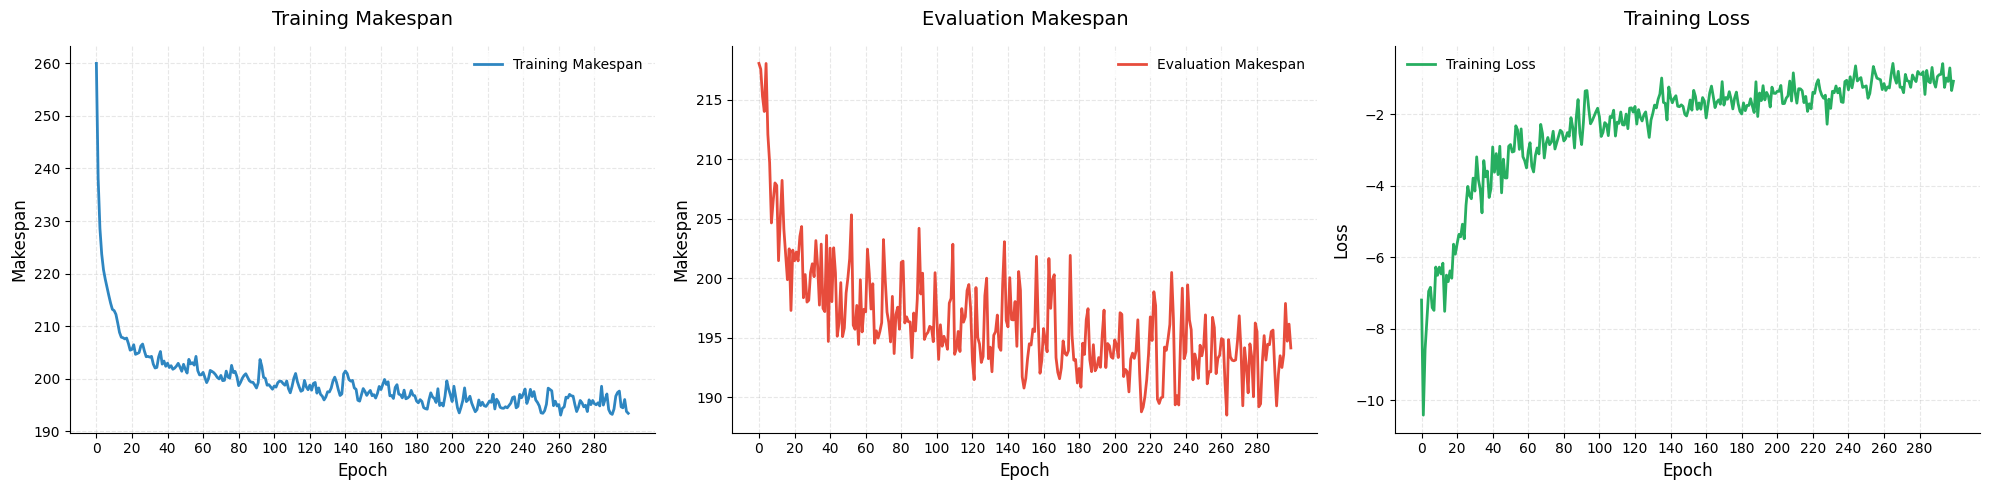

In [ ]:
if __name__ == "__main__":
    trained_agent, ms_history, eval_ms_history, loss_history = train_agent(num_epochs=300, num_batch=50, batch_size=7, eval_size=100, device='cuda')
    
    plot_training_curves(ms_history, eval_ms_history, loss_history, x_tick_size=20)

## 모델 저장

In [125]:
import os

def save_agent(agent, path):
    """
    Save the REINFORCE agent's state
    """
    save_dict = {
        'policy_net_state': agent.policy_net.state_dict(),
        'optimizer_state': agent.optimizer.state_dict(),
        'machine_names': agent.machine_names,
        'num_actions': agent.num_actions,
        'device': agent.device
    }
    torch.save(save_dict, path)

def load_agent(path, state_dim, hidden_dim, num_layers, lr=1e-3):
    """
    Load a saved REINFORCE agent
    """
    checkpoint = torch.load(path)
    
    # Recreate agent with saved parameters
    agent = REINFORCEAgent(
        state_dim=state_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        num_actions=checkpoint['num_actions'],
        machine_names=checkpoint['machine_names'],
        lr=lr,
        device=checkpoint['device']
    )
    
    # Load saved states
    agent.policy_net.load_state_dict(checkpoint['policy_net_state'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state'])
    
    return agent

# Save agent
save_path = './POMO_model/20_lots/reinforce_agent_4machine.pth'
save_agent(trained_agent, save_path)

# Load agent
# loaded_agent = load_agent(
#     path='reinforce_agent.pth',
#     state_dim=state_dim,  # Use same dimensions as original agent
#     hidden_dim=hidden_dim,
#     num_layers=num_layers
# )


## 테스트 데이터 시각화


Best POMO Solution:
Makespan: 193.00
Total jobs completed: 20

작업 상세:
Machine: M4, Lot: L02, Process: P03, Time: 10 -> 36
Machine: M3, Lot: L01, Process: P04, Time: 2 -> 43
Machine: M1, Lot: L03, Process: P07, Time: 13 -> 49
Machine: M3, Lot: L05, Process: P06, Time: 43 -> 63
Machine: M4, Lot: L10, Process: P05, Time: 50 -> 71
Machine: M2, Lot: L08, Process: P09, Time: 39 -> 77
Machine: M1, Lot: L07, Process: P02, Time: 49 -> 83
Machine: M3, Lot: L09, Process: P01, Time: 63 -> 88
Machine: M4, Lot: L11, Process: P05, Time: 71 -> 92
Machine: M1, Lot: L16, Process: P01, Time: 83 -> 114
Machine: M3, Lot: L06, Process: P08, Time: 93 -> 129
Machine: M4, Lot: L17, Process: P02, Time: 92 -> 129
Machine: M2, Lot: L18, Process: P04, Time: 87 -> 130
Machine: M2, Lot: L04, Process: P10, Time: 130 -> 153
Machine: M1, Lot: L13, Process: P09, Time: 114 -> 154
Machine: M4, Lot: L12, Process: P03, Time: 130 -> 156
Machine: M3, Lot: L14, Process: P08, Time: 129 -> 165
Machine: M2, Lot: L15, Process: P1

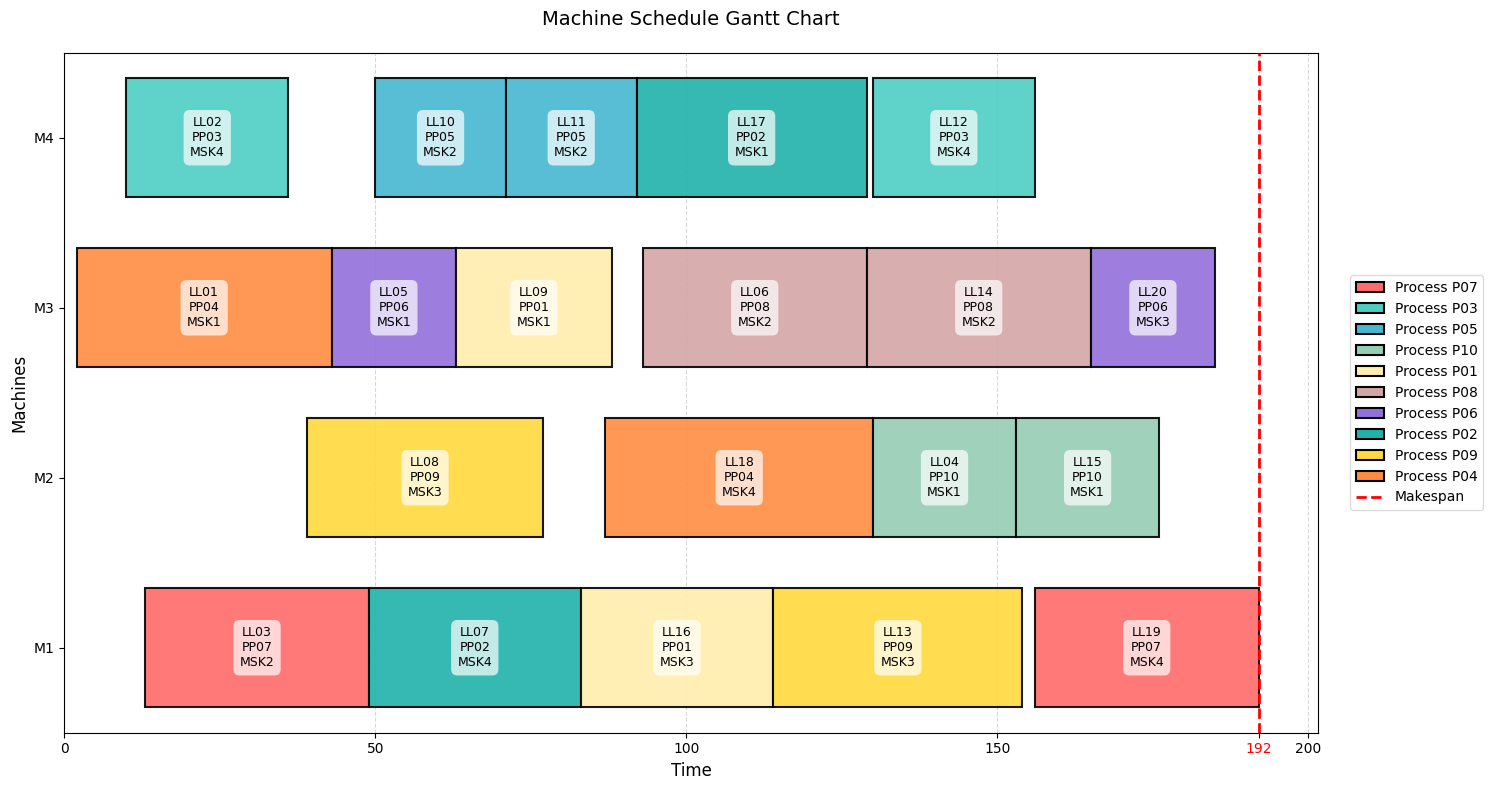

In [ ]:
instance_data = generate_instance_data()
machines = extract_machine_names(instance_data)

fig, ax, history = create_pomo_gantt_chart(instance_data, trained_agent, machines)

print("\n작업 상세:")
for job in history:
    print(f"Machine: {job['machine']}, "
          f"Lot: {job['lot_id']}, "
          f"Process: {job['process_id']}, "
          f"Time: {job['start_time']} -> {job['start_time'] + job['duration']}")

plt.show()